# ETL Assigment<br>
![etl](https://www.pngitem.com/pimgs/m/537-5379917_extract-transform-load-logo-hd-png-download.png)
<br>
### Problem Defination
In this assigment, Data need to be loaded from source. Transformed in such a fashion that output should be a database supported (sql) file. Transformation that need be done is adding an extra column which will contain date and time.<br>
### Points that need to be covered
* **When loading files, only specific files need to be loaded.**
* **New field should be added to existing data which will contain Date and timestamp.**
* **Output should be a sql file/dump.**

## ETL Process
### by Abhishek Padghane as follows:

* Getting some random files and storing it in data folder.
* Getting files which consist data for ETL and renaming them according to problem statement.
* Loading the files as pandas Dataframe.
* Performing required analysis.
* Saving files in database (sql format).

## Third party libraries
![pandas](https://upload.wikimedia.org/wikipedia/commons/thumb/e/ed/Pandas_logo.svg/1200px-Pandas_logo.svg.png)
![sqlalchemy](https://hakin9.org/wp-content/uploads/2019/08/connect-a-flask-app-to-a-mysql-database-with-sqlalchemy-and-pymysql.jpg)
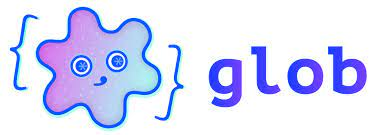
![dotenv](https://raw.githubusercontent.com/motdotla/dotenv/master/dotenv.png)

In [1]:
# importing required libraries

# re for regular expression
import re

# os for system related operations
import os

# glob for extracting required files
import glob

# dotenv to read credentials as environmental variables
import dotenv

# pandas for data processing
import pandas

# warnings for handle warning
import warnings

# datetime for date and time related operations
import datetime

# sqlalchemy for connection with mariadb DBMS application
import sqlalchemy

# hiding all warnings
warnings.filterwarnings('ignore')

![etl](https://www.astera.com/wp-content/uploads/2019/10/etl.png)

## EXTRACT
In this process, i am extracting my data from **.csv**(comma separated value) format.<br>
Rules are:
* File name should be like "Analytics_dd_mm_yyyy"
* File format should be csv<br>
using `glob.glob`(*regex*) for getting file name based on search pattern

In [2]:
# initializing data directory
data_directory = "Analytics"

# initializing date pattern regex
date_pattern = r"[0-9][0-9]-[0-9][0-9]-[0-9][0-9][0-9][0-9]"

# initializing regex for searching files
file_search_pattern = data_directory + "_" + date_pattern

# initializing file format, in our case its csv
file_format = ".csv"

# getting files with path associated
data_files = glob.glob(os.path.join(data_directory, file_search_pattern + file_format))

# displaying files
print("Files are:\n")
for files in data_files:
    print(files[len(data_directory)+1:])

Files are:

Analytics_14-05-2021.csv
Analytics_18-05-2021.csv
Analytics_24-06-2021.csv
Analytics_25-06-2021.csv


Using `pandas.read_csv`(*file path*) for reading data into `pandas.DataFrame()` API.<br>
Storing all files Dataframes into a `List`

In [3]:
# reading data of files, using pandas DataFrame API / Data structure for our data
data_files_df_list = list(map(pandas.read_csv, data_files))

Analyzing **schema** of one of the df, considered all df schema are similar.

In [4]:
# displaying schema
print("Fields are:\n")
for column in data_files_df_list[0].columns:
    print(column)

Fields are:

Date
Symbol
Series
Prev Close
Open
High
Low
Last
Close
VWAP
Volume
Turnover
Trades
Deliverable Volume
%Deliverble


In [5]:
# Analyzing file by looking first 5 values of one of the file
data_files_df_list[0].head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2000-01-03,GAIL,EQ,67.80,65.00,70.0,65.0,68.80,68.70,67.91,76055,5.165166e+11,NaN,NaN,NaN
1,2000-01-04,GAIL,EQ,68.70,69.85,72.9,66.0,67.00,66.35,67.29,98097,6.600457e+11,NaN,NaN,NaN
2,2000-01-05,GAIL,EQ,66.35,68.35,68.7,61.1,63.00,63.20,65.24,92690,6.046889e+11,NaN,NaN,NaN
3,2000-01-06,GAIL,EQ,63.20,64.80,67.0,63.0,64.75,64.95,65.55,173654,1.138299e+12,NaN,NaN,NaN
4,2000-01-07,GAIL,EQ,64.95,65.90,65.9,62.0,62.90,62.65,63.76,86590,5.521388e+11,NaN,NaN,NaN


Analyzing columns of all df where sum of null values is greater than 0

In [6]:
# analyzing which columns have null values greater than 0

print("Checking columns with null values:\n\n")
for files, df in zip(data_files, data_files_df_list):
    print(f"Columns with higher null total then other columns in {files[len(data_directory)+1:]}:\n")
    display_list = []
    
    # adding fields and nul value total which is higher than 0 in a list
    for field, null_val in zip(df.columns, df.isnull().sum()):
        if null_val > 0:
            display_list.append([field, str(null_val)])
    
    # printing field and nul value total
    for display in display_list:
        for entry in display:
            print(entry.ljust(25), end='')
        print()
    print("\n")

Checking columns with null values:


Columns with higher null total then other columns in Analytics_14-05-2021.csv:

Trades                   2529                     
Deliverable Volume       188                      
%Deliverble              188                      


Columns with higher null total then other columns in Analytics_18-05-2021.csv:

Trades                   2850                     
Deliverable Volume       514                      
%Deliverble              514                      


Columns with higher null total then other columns in Analytics_24-06-2021.csv:

Trades                   2850                     
Deliverable Volume       509                      
%Deliverble              509                      


Columns with higher null total then other columns in Analytics_25-06-2021.csv:

Trades                   2850                     
Deliverable Volume       514                      
%Deliverble              514                      




## TRANSFORM
Now as we can see, **Trades, Deliverable Volume, %Deliverble** have high number of null value sum, removing them. Using `pandas.DataFrame.drop`(*columns, inplace=False, axis=0* )

In [7]:
# removing fields that consists higher nulls
higher_null_columns = ["Trades", "Deliverable Volume", "%Deliverble"]

for df in data_files_df_list:
    df.drop(columns=higher_null_columns, inplace=True, axis=1)

In [8]:
# Analyzing file by looking first 5 values after removal of above columns
data_files_df_list[0].head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover
0,2000-01-03,GAIL,EQ,67.80,65.00,70.0,65.0,68.80,68.70,67.91,76055,5.165166e+11
1,2000-01-04,GAIL,EQ,68.70,69.85,72.9,66.0,67.00,66.35,67.29,98097,6.600457e+11
2,2000-01-05,GAIL,EQ,66.35,68.35,68.7,61.1,63.00,63.20,65.24,92690,6.046889e+11
3,2000-01-06,GAIL,EQ,63.20,64.80,67.0,63.0,64.75,64.95,65.55,173654,1.138299e+12
4,2000-01-07,GAIL,EQ,64.95,65.90,65.9,62.0,62.90,62.65,63.76,86590,5.521388e+11


Assigning a new column **File_Date_Time** for storing datetime of csv files.

In [9]:
# initializing datetime format
date_time_format = "%d-%m-%Y"

# making a new column which consist the datetime of file
for files, df in zip(data_files, data_files_df_list):
    df["File_Date_Time"] = datetime.datetime.strptime(re.search(date_pattern, files).group(), date_time_format)

In [10]:
# Analyzing file by looking first 5 values after transformation
data_files_df_list[1].head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,File_Date_Time
0,2000-01-03,RELIANCE,EQ,233.05,237.50,251.70,237.50,251.70,251.70,249.37,4456424,1.111319e+14,2021-05-18
1,2000-01-04,RELIANCE,EQ,251.70,258.40,271.85,251.30,271.85,271.85,263.52,9487878,2.500222e+14,2021-05-18
2,2000-01-05,RELIANCE,EQ,271.85,256.65,287.90,256.65,286.75,282.50,274.79,26833684,7.373697e+14,2021-05-18
3,2000-01-06,RELIANCE,EQ,282.50,289.00,300.70,289.00,293.50,294.35,295.45,15682286,4.633254e+14,2021-05-18
4,2000-01-07,RELIANCE,EQ,294.35,295.00,317.90,293.00,314.50,314.55,308.91,19870977,6.138388e+14,2021-05-18


In [11]:
# checking data types of columns
data_files_df_list[0].dtypes

Date                      object
Symbol                    object
Series                    object
Prev Close               float64
Open                     float64
High                     float64
Low                      float64
Last                     float64
Close                    float64
VWAP                     float64
Volume                     int64
Turnover                 float64
File_Date_Time    datetime64[ns]
dtype: object

## LOAD
Making connection to mariadb dbms. First loading db credentials as environment variable using `dotenv.load_dotenv()` then `sqlalchemy.create_engine()` for db connection.

In [12]:
# loading db credentials as environment variables
dotenv.load_dotenv()

# making a db connection
database_connection = sqlalchemy.create_engine(f'mysql+mysqlconnector://{os.environ["USER"]}:{os.environ["PASS"]}@'
                           f'{os.environ["HOST"]}:{os.environ["PORT"]}/{os.environ["NAME"]}')

Writing df into db tables using `pandas.DataFrame.to_sql()`

In [13]:
# saving/writing df to sql tables
for df_pos, file_name in zip(range(len(data_files_df_list)), data_files):
    
    # initializing table name
    table_name = "_".join(file_name[len(data_directory)+1:-4].split("-"))
    
    # writing data in sql table
    data_files_df_list[df_pos].to_sql(con=database_connection, name=table_name, if_exists='replace')